# Load tests with K6


In [1]:
import os
from dotenv import load_dotenv

%load_ext autoreload
%autoreload 2

load_dotenv(override=True)

True

## 0. Lookup compatible configs


First, get IE compute instance options


In [2]:
from autobench.compute_manager import ComputeManager

In [3]:
compute_manager = ComputeManager()
compute_manager.options.head()

,vendor,vendor_status,region,region_label,region_status,id,accelerator,num_gpus,memory_in_gb,gpu_memory_in_gb,instance_type,instance_size,architecture,status,price_per_hour,num_cpus
0,aws,available,us-east-1,N. Virginia,available,aws-us-east-1-nvidia-t4-x1,gpu,1,15,16,nvidia-t4,x1,Nvidia T4,available,0.5,3
1,aws,available,us-east-1,N. Virginia,available,aws-us-east-1-nvidia-t4-x4,gpu,4,192,64,nvidia-t4,x4,Nvidia T4,available,3.0,46
2,aws,available,us-east-1,N. Virginia,available,aws-us-east-1-nvidia-a10g-x1,gpu,1,30,24,nvidia-a10g,x1,Nvidia A10G,available,1.0,6
3,aws,available,us-east-1,N. Virginia,available,aws-us-east-1-nvidia-a10g-x4,gpu,4,186,96,nvidia-a10g,x4,Nvidia A10G,available,5.0,46
4,aws,available,us-east-1,N. Virginia,available,aws-us-east-1-nvidia-a100-x1,gpu,1,145,80,nvidia-a100,x1,Nvidia A100,available,4.0,11


In [4]:
compute_manager.options.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   vendor            21 non-null     object 
 1   vendor_status     21 non-null     object 
 2   region            21 non-null     object 
 3   region_label      21 non-null     object 
 4   region_status     21 non-null     object 
 5   id                21 non-null     object 
 6   accelerator       21 non-null     object 
 7   num_gpus          21 non-null     int64  
 8   memory_in_gb      21 non-null     int64  
 9   gpu_memory_in_gb  21 non-null     int64  
 10  instance_type     21 non-null     object 
 11  instance_size     21 non-null     object 
 12  architecture      21 non-null     object 
 13  status            21 non-null     object 
 14  price_per_hour    21 non-null     float64
 15  num_cpus          21 non-null     int64  
dtypes: float64(1), int64(4), object(11)
memory usa

User specifies their desired inputs


In [6]:
VENDOR = "aws"
REGION = "us-east-1"
# REGION = "eu-west-1"
GPU_TYPES = ["nvidia-a10g", "nvidia-l4"]
GPU_TYPES = ["nvidia-a10g"]

In [7]:
possible_instances = compute_manager.get_instance_details(
    vendor=VENDOR, region=REGION, gpu_types=GPU_TYPES
)

In [8]:
len(possible_instances)

2

Then, check if model will work on any of the desired instances, and if so, get each TGI config


In [9]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

viable_instances = compute_manager.get_viable_instance_configs(
    model_id=model_id, instances=possible_instances
)

In [10]:
viable_instances

[{'tgi_config': TGIConfig(model_id='meta-llama/Meta-Llama-3-8B-Instruct', max_batch_prefill_tokens=8192, max_input_length=6000, max_total_tokens=6144, num_shard=1, quantize=None, estimated_memory_in_gigabytes=23.01),
  'instance_config': ComputeInstanceConfig(id='aws-us-east-1-nvidia-a10g-x1', vendor='aws', vendor_status='available', region='us-east-1', region_label='N. Virginia', region_status='available', accelerator='gpu', num_gpus=1, memory_in_gb=30, gpu_memory_in_gb=24, instance_type='nvidia-a10g', instance_size='x1', architecture='Nvidia A10G', status='available', price_per_hour=1.0, num_cpus=6)},
 {'tgi_config': TGIConfig(model_id='meta-llama/Meta-Llama-3-8B-Instruct', max_batch_prefill_tokens=32768, max_input_length=6000, max_total_tokens=6144, num_shard=4, quantize=None, estimated_memory_in_gigabytes=98.36),
  'instance_config': ComputeInstanceConfig(id='aws-us-east-1-nvidia-a10g-x4', vendor='aws', vendor_status='available', region='us-east-1', region_label='N. Virginia', regi

## 1. Deploy LLM with TGI on Inference Endpoints


In [42]:
from autobench.deployment import Deployment
from autobench.config import DeploymentConfig

In [44]:
viable_instance = viable_instances[0]
viable_instance

{'tgi_config': TGIConfig(model_id='meta-llama/Meta-Llama-3-8B-Instruct', max_batch_prefill_tokens=8192, max_input_length=6000, max_total_tokens=6144, num_shard=1, quantize=None, estimated_memory_in_gigabytes=23.01),
 'instance_config': ComputeInstanceConfig(id='aws-us-east-1-nvidia-a10g-x1', vendor='aws', vendor_status='available', region='us-east-1', region_label='N. Virginia', region_status='available', accelerator='gpu', num_gpus=1, memory_in_gb=30, gpu_memory_in_gb=24, instance_type='nvidia-a10g', instance_size='x1', architecture='Nvidia A10G', status='available', price_per_hour=1.0, num_cpus=6)}

In [49]:
viable_instances[:1]

[{'tgi_config': TGIConfig(model_id='meta-llama/Meta-Llama-3-8B-Instruct', max_batch_prefill_tokens=8192, max_input_length=6000, max_total_tokens=6144, num_shard=1, quantize=None, estimated_memory_in_gigabytes=23.01),
  'instance_config': ComputeInstanceConfig(id='aws-us-east-1-nvidia-a10g-x1', vendor='aws', vendor_status='available', region='us-east-1', region_label='N. Virginia', region_status='available', accelerator='gpu', num_gpus=1, memory_in_gb=30, gpu_memory_in_gb=24, instance_type='nvidia-a10g', instance_size='x1', architecture='Nvidia A10G', status='available', price_per_hour=1.0, num_cpus=6)}]

In [45]:
viable_instance["tgi_config"].env_vars

{'MAX_BATCH_PREFILL_TOKENS': '8192',
 'MAX_INPUT_LENGTH': '6000',
 'MAX_TOTAL_TOKENS': '6144',
 'NUM_SHARD': '1',
 'MODEL_ID': '/repository'}

In [46]:
deployment_config = DeploymentConfig(
    tgi_config=viable_instance["tgi_config"],
    instance_config=viable_instance["instance_config"],
)

In [47]:
deployment = Deployment(deployment_config)

# deployment = Deployment(
#     deployment_config, existing_endpoint_name="d30f3a82-95b9-44e8-b0ca-617d17cc"
# )

Creating inference endpoint...
Endpoint created successfully: https://p6t119srp8ybkzus.us-east-1.aws.endpoints.huggingface.cloud


In [15]:
deployment.deployment_id, deployment.endpoint.status, deployment.endpoint.url

('d30f3a82-95b9-44e8-b0ca-617d17cc',
 'running',
 'https://ehdndzfif3v55m3w.us-east-1.aws.endpoints.huggingface.cloud')

## 2. Prepare ShareGPT data for realisitic inference workload


In [16]:
from autobench.config import DataConfig
from autobench.data import BenchmarkDataset

data_config = DataConfig()
benchmark_dataset = BenchmarkDataset(data_config)
benchmark_dataset.build_data()

100%|█████████▉| 1999/2000 [00:00<00:00, 47239.06it/s]


In [17]:
data_config.file_path

'benchmark_data/data.json'

## 2. Run K6 Load Test


In [18]:
# If necessary, install the openai Python library by running
# pip install openai

import requests
from huggingface_hub import get_token


API_URL = f"{deployment.endpoint.url}" + "/v1/chat/completions"
headers = {
    "Accept": "application/json",
    "Authorization": f"Bearer {get_token()}",
    "Content-Type": "application/json",
}


def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response


output = query(
    {
        "messages": [{"role": "user", "content": "How old is Statute of Liberty?"}],
        "max_tokens": 150,
        "model": "tgi",
    }
)

In [19]:
print(output.content)

b'{"object":"chat.completion","id":"","created":1725459405,"model":"/repository","system_fingerprint":"2.2.1-dev0-sha-6cb42f4","choices":[{"index":0,"message":{"role":"assistant","content":"The Statue of Liberty was dedicated on October 28, 1886. It was designed by French sculptor Fr\xc3\xa9d\xc3\xa9ric Auguste Bartholdi and was a gift from the people of France to the people of the United States.\\n\\nThe statue was built in France and then taken apart and shipped to New York Harbor, where it was reassembled on Bedloe\'s Island (now known as Liberty Island) in New York City. The statue was officially dedicated on October 28, 1886, in a ceremony presided over by President Grover Cleveland.\\n\\nSo, as of 2023, the Statue of Liberty is approximately 137 years old."},"logprobs":null,"finish_reason":"stop"}],"usage":{"prompt_tokens":18,"completion_tokens":133,"total_tokens":151}}'


In [20]:
from autobench.runner import (
    K6ConstantArrivalRateExecutor,
    Scenario,
)

In [21]:
executor = K6ConstantArrivalRateExecutor(
    pre_allocated_vus=10, rate_per_second=1, duration="10s"
)

In [22]:
benchmark_dataset.file_path

'/Users/andrewreed/Documents/success_projects/auto-bench/benchmark_data/data.json'

In [23]:
scenario = Scenario(
    host=deployment.endpoint.url,
    executor=executor,
    data_file=benchmark_dataset.file_path,
    output_dir=os.path.abspath("../autobench/benchmark_results"),
)

In [24]:
scenario.run()

Preparing scenario 28883518-badd-4bf1-bcf3-e93317f9c0c6
Running scenario 28883518-badd-4bf1-bcf3-e93317f9c0c6

          /\      |‾‾| /‾‾/   /‾‾/   
     /\  /  \     |  |/  /   /  /    
    /  \/    \    |     (   /   ‾‾\  
   /          \   |  |\  \ |  (‾)  | 
  / __________ \  |__| \__\ \_____/ .io

     execution: local
        script: /var/folders/w0/6t9rxkj97rv47l9sc0q22yth0000gn/T/autobench_0qbcyi7u_k6_script.js
        output: json (/Users/andrewreed/Documents/success_projects/auto-bench/autobench/benchmark_results/scenario_28883518-badd-4bf1-bcf3-e93317f9c0c6/results.json)

     scenarios: (100.00%) 1 scenario, 10 max VUs, 40s max duration (incl. graceful stop):
              * load_test: 1.00 iterations/s for 10s (maxVUs: 10, gracefulStop: 30s)


running (01.0s), 01/10 VUs, 0 complete and 0 interrupted iterations
load_test   [  10% ] 01/10 VUs  01.0s/10s  1.00 iters/s

running (02.0s), 02/10 VUs, 0 complete and 0 interrupted iterations
load_test   [  20% ] 02/10 VUs  02.0s/10

In [26]:
scenario.scenario_id

'28883518-badd-4bf1-bcf3-e93317f9c0c6'

## Benchmark Runner

In [28]:
from autobench.runner import BenchmarkRunner

In [31]:
benchmark_runner = BenchmarkRunner(
    deployment=deployment,
    benchmark_dataset=benchmark_dataset,
    output_dir=os.path.abspath("../autobench/benchmark_results"),
)

In [32]:
deployment.endpoint.url

'https://ehdndzfif3v55m3w.us-east-1.aws.endpoints.huggingface.cloud'

In [43]:
deployment.endpoint.delete()

InferenceEndpoint(name='d30f3a82-95b9-44e8-b0ca-617d17cc', namespace='andrewrreed', repository='meta-llama/Meta-Llama-3-8B-Instruct', status='running', url='https://ehdndzfif3v55m3w.us-east-1.aws.endpoints.huggingface.cloud')

In [33]:
benchmark_runner.run_benchmark()

Running benchmark for deployment d30f3a82-95b9-44e8-b0ca-617d17cc
Running benchmark for arrival rate 1
Preparing scenario f2f19166-3e7d-4160-bcae-b05d55be8be1
Running scenario f2f19166-3e7d-4160-bcae-b05d55be8be1

          /\      |‾‾| /‾‾/   /‾‾/   
     /\  /  \     |  |/  /   /  /    
    /  \/    \    |     (   /   ‾‾\  
   /          \   |  |\  \ |  (‾)  | 
  / __________ \  |__| \__\ \_____/ .io

     execution: local
        script: /var/folders/w0/6t9rxkj97rv47l9sc0q22yth0000gn/T/autobench_au38ivak_k6_script.js
        output: json (/Users/andrewreed/Documents/success_projects/auto-bench/autobench/benchmark_results/deployment_d30f3a82-95b9-44e8-b0ca-617d17cc/scenario_f2f19166-3e7d-4160-bcae-b05d55be8be1/results.json)

     scenarios: (100.00%) 1 scenario, 50 max VUs, 35s max duration (incl. graceful stop):
              * load_test: 1.00 iterations/s for 5s (maxVUs: 50, gracefulStop: 30s)


running (00.9s), 01/50 VUs, 0 complete and 0 interrupted iterations
load_test   [  17% 

## Scheduler

In [34]:
vi = viable_instances[0]

In [38]:
vi["instance_config"].instance_type, vi["instance_config"].vendor, vi[
    "instance_config"
].num_gpus

('nvidia-a10g', 'aws', 1)

In [36]:
vi

{'tgi_config': TGIConfig(model_id='meta-llama/Meta-Llama-3-8B-Instruct', max_batch_prefill_tokens=8192, max_input_length=6000, max_total_tokens=6144, num_shard=1, quantize=None, estimated_memory_in_gigabytes=23.01),
 'instance_config': ComputeInstanceConfig(id='aws-us-east-1-nvidia-a10g-x1', vendor='aws', vendor_status='available', region='us-east-1', region_label='N. Virginia', region_status='available', accelerator='gpu', num_gpus=1, memory_in_gb=30, gpu_memory_in_gb=24, instance_type='nvidia-a10g', instance_size='x1', architecture='Nvidia A10G', status='available', price_per_hour=1.0, num_cpus=6)}

In [39]:
viable_instances

[{'tgi_config': TGIConfig(model_id='meta-llama/Meta-Llama-3-8B-Instruct', max_batch_prefill_tokens=8192, max_input_length=6000, max_total_tokens=6144, num_shard=1, quantize=None, estimated_memory_in_gigabytes=23.01),
  'instance_config': ComputeInstanceConfig(id='aws-us-east-1-nvidia-a10g-x1', vendor='aws', vendor_status='available', region='us-east-1', region_label='N. Virginia', region_status='available', accelerator='gpu', num_gpus=1, memory_in_gb=30, gpu_memory_in_gb=24, instance_type='nvidia-a10g', instance_size='x1', architecture='Nvidia A10G', status='available', price_per_hour=1.0, num_cpus=6)},
 {'tgi_config': TGIConfig(model_id='meta-llama/Meta-Llama-3-8B-Instruct', max_batch_prefill_tokens=32768, max_input_length=6000, max_total_tokens=6144, num_shard=4, quantize=None, estimated_memory_in_gigabytes=98.36),
  'instance_config': ComputeInstanceConfig(id='aws-us-east-1-nvidia-a10g-x4', vendor='aws', vendor_status='available', region='us-east-1', region_label='N. Virginia', regi

In [27]:
from huggingface_hub.constants import INFERENCE_ENDPOINTS_ENDPOINT
from huggingface_hub.utils import get_session, hf_raise_for_status, build_hf_headers


def fetch_quotas(namespace: str):
    """
    Fetch quotas for a given namespace.

    Args:
        namespace (str): The namespace to fetch quotas for.

    Returns:
        dict: The quotas for the given namespace.
    """
    session = get_session()
    response = session.get(
        f"{INFERENCE_ENDPOINTS_ENDPOINT}/provider/quotas/{namespace}",
        headers=build_hf_headers(),
    )
    hf_raise_for_status(response)

    return response.json()

In [28]:
from huggingface_hub import whoami

In [29]:
whoami()

{'type': 'user',
 'id': '61d375fd733d3a83ecd1bba9',
 'name': 'andrewrreed',
 'fullname': 'Andrew Reed',
 'email': 'andrew.reed@huggingface.co',
 'emailVerified': True,
 'canPay': True,
 'periodEnd': 1727740799,
 'isPro': False,
 'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/61d375fd733d3a83ecd1bba9/oIXwvvs1-HaCnJXMCZgkc.jpeg',
 'orgs': [{'type': 'org',
   'id': '5e67bd5b1009063689407478',
   'name': 'huggingface',
   'fullname': 'Hugging Face',
   'email': 'website@huggingface.co',
   'canPay': True,
   'periodEnd': 1727740799,
   'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/1583856921041-5dd96eb166059660ed1ee413.png',
   'roleInOrg': 'contributor',
   'isEnterprise': True},
  {'type': 'org',
   'id': '61f4051081c4d30f5814022f',
   'name': 'demo-org',
   'fullname': 'Demo Corp',
   'email': 'jeff@huggingface.co',
   'canPay': False,
   'periodEnd': 1727740799,
   'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/16

In [30]:
fetch_quotas("andrewrreed")

{'vendors': [{'name': 'aws',
   'quotas': [{'instanceType': 'intel-spr',
     'architecture': 'Intel Sapphire Rapids',
     'maxAccelerators': 40,
     'usedAccelerators': 0},
    {'instanceType': 'nvidia-a10g',
     'architecture': 'Nvidia A10G',
     'maxAccelerators': 8,
     'usedAccelerators': 3},
    {'instanceType': 'nvidia-t4',
     'architecture': 'Nvidia T4',
     'maxAccelerators': 15,
     'usedAccelerators': 0},
    {'instanceType': 'intel-icl',
     'architecture': 'Intel Ice Lake',
     'maxAccelerators': 40,
     'usedAccelerators': 0},
    {'instanceType': 'inf2',
     'architecture': 'AWS Inferentia 2',
     'maxAccelerators': 24,
     'usedAccelerators': 0},
    {'instanceType': 'nvidia-l4',
     'architecture': 'Nvidia L4',
     'maxAccelerators': 8,
     'usedAccelerators': 0},
    {'instanceType': 'nvidia-a100',
     'architecture': 'Nvidia A100',
     'maxAccelerators': 2,
     'usedAccelerators': 0}]},
  {'name': 'azure',
   'quotas': [{'instanceType': 'intel-xe

In [ ]:
aws - us - east - 1 - nvidia - a10g - x4

In [45]:
compute_manager.get_tgi_config(
    model_id="NousResearch/Hermes-3-Llama-3.1-8B", gpu_memory=24 * 4, num_gpus=4
)

2024-09-11 08:07:03.511 | INFO     | autobench.compute_manager:get_tgi_config:174 - Fetching TGI config for model_id=NousResearch/Hermes-3-Llama-3.1-8B, gpu_memory=96, num_gpus=4
2024-09-11 08:07:03.933 | ERROR    | autobench.compute_manager:get_tgi_config:189 - HTTP error occurred while fetching TGI config: 400 Client Error: Bad Request for url: https://huggingface.co/api/integrations/tgi/v1/config?model_id=NousResearch%2FHermes-3-Llama-3.1-8B&gpu_memory=96&num_gpus=4. Detail: Model NousResearch/Hermes-3-Llama-3.1-8B is not a TGI model, There is no specific config for this model.


In [46]:
compute_manager.get_tgi_config(
    model_id="meta-llama/Meta-Llama-3-8B-Instruct", gpu_memory=24 * 4, num_gpus=4
)

2024-09-11 08:07:03.953 | INFO     | autobench.compute_manager:get_tgi_config:174 - Fetching TGI config for model_id=meta-llama/Meta-Llama-3-8B-Instruct, gpu_memory=96, num_gpus=4
2024-09-11 08:07:04.558 | DEBUG    | autobench.compute_manager:get_tgi_config:180 - Successfully retrieved TGI config


{'config': {'model_id': 'meta-llama/Meta-Llama-3-8B-Instruct',
  'max_batch_prefill_tokens': 16384,
  'max_input_length': 6000,
  'max_total_tokens': 6144,
  'num_shard': 4,
  'quantize': None,
  'estimated_memory_in_gigabytes': 40.76}}

In [43]:
vi = compute_manager.get_viable_instance_configs(
    model_id="meta-llama/Meta-Llama-3-8B-Instruct",
    instances=possible_instances,
)
vi

2024-09-10 12:25:11.966 | INFO     | autobench.compute_manager:get_viable_instance_configs:211 - Finding viable instance configs for model_id=meta-llama/Meta-Llama-3-8B-Instruct
2024-09-10 12:25:11.967 | INFO     | autobench.compute_manager:get_tgi_config:174 - Fetching TGI config for model_id=meta-llama/Meta-Llama-3-8B-Instruct, gpu_memory=24, num_gpus=1


Num GPUs: 1
Total GPU Memory: 24



2024-09-10 12:25:12.199 | DEBUG    | autobench.compute_manager:get_tgi_config:180 - Successfully retrieved TGI config
2024-09-10 12:25:12.200 | INFO     | autobench.config:__post_init__:16 - Initializing TGIConfig for model: meta-llama/Meta-Llama-3-8B-Instruct
2024-09-10 12:25:12.201 | DEBUG    | autobench.config:__post_init__:26 - TGIConfig environment variables set: {'MAX_BATCH_PREFILL_TOKENS': '8192', 'MAX_INPUT_LENGTH': '6000', 'MAX_TOTAL_TOKENS': '6144', 'NUM_SHARD': '1', 'MODEL_ID': '/repository'}
2024-09-10 12:25:12.201 | INFO     | autobench.config:__post_init__:49 - Initializing ComputeInstanceConfig for instance: aws-us-east-1-nvidia-a10g-x1
2024-09-10 12:25:12.202 | DEBUG    | autobench.config:__post_init__:50 - ComputeInstanceConfig details: vendor=aws, region=us-east-1, accelerator=gpu
2024-09-10 12:25:12.202 | DEBUG    | autobench.compute_manager:get_viable_instance_configs:232 - Found viable instance: aws-us-east-1-nvidia-a10g-x1
2024-09-10 12:25:12.203 | INFO     | auto

Num GPUs: 4
Total GPU Memory: 96



[{'tgi_config': TGIConfig(model_id='meta-llama/Meta-Llama-3-8B-Instruct', max_batch_prefill_tokens=8192, max_input_length=6000, max_total_tokens=6144, num_shard=1, quantize=None, estimated_memory_in_gigabytes=23.01),
  'instance_config': ComputeInstanceConfig(id='aws-us-east-1-nvidia-a10g-x1', vendor='aws', vendor_status='available', region='us-east-1', region_label='N. Virginia', region_status='available', accelerator='gpu', num_gpus=1, memory_in_gb=30, gpu_memory_in_gb=24, instance_type='nvidia-a10g', instance_size='x1', architecture='Nvidia A10G', status='available', price_per_hour=1.0, num_cpus=6)},
 {'tgi_config': TGIConfig(model_id='meta-llama/Meta-Llama-3-8B-Instruct', max_batch_prefill_tokens=16384, max_input_length=6000, max_total_tokens=6144, num_shard=4, quantize=None, estimated_memory_in_gigabytes=40.76),
  'instance_config': ComputeInstanceConfig(id='aws-us-east-1-nvidia-a10g-x4', vendor='aws', vendor_status='available', region='us-east-1', region_label='N. Virginia', regi

In [44]:
print(vi[1]["tgi_config"])
print()
print(vi[1]["instance_config"])

TGIConfig(model_id='meta-llama/Meta-Llama-3-8B-Instruct', max_batch_prefill_tokens=16384, max_input_length=6000, max_total_tokens=6144, num_shard=4, quantize=None, estimated_memory_in_gigabytes=40.76)

ComputeInstanceConfig(id='aws-us-east-1-nvidia-a10g-x4', vendor='aws', vendor_status='available', region='us-east-1', region_label='N. Virginia', region_status='available', accelerator='gpu', num_gpus=4, memory_in_gb=186, gpu_memory_in_gb=96, instance_type='nvidia-a10g', instance_size='x4', architecture='Nvidia A10G', status='available', price_per_hour=5.0, num_cpus=46)


## Reporting

- Accepts scheduler_id, looks up files
- parses results into dataframe
- visualizes results

In [1]:
def gather_results(scheduler_results_dir: str):

    

In [5]:
import os

SCHEDULER_RESULT_DIR = "/Users/andrewreed/Documents/success_projects/auto-bench/autobench/benchmark_results/scheduler_efaff1dc-e275-42e2-9fdc-2b330de97d12"

['deployment_statuses.json',
 'deployment_47eb12dd-d256-408e-ae1d-3a8787c3',
 'deployment_3a63481f-84f7-4120-ba6a-930f94f3']

In [32]:
from autobench.report import gather_results, plot_metrics

In [35]:
DIR = "/Users/andrewreed/Documents/success_projects/auto-bench/autobench/benchmark_results/scheduler_8b5be517-3d1d-4a99-a783-6af76b99f99f"
results_df = gather_results(scheduler_results_dir=DIR)

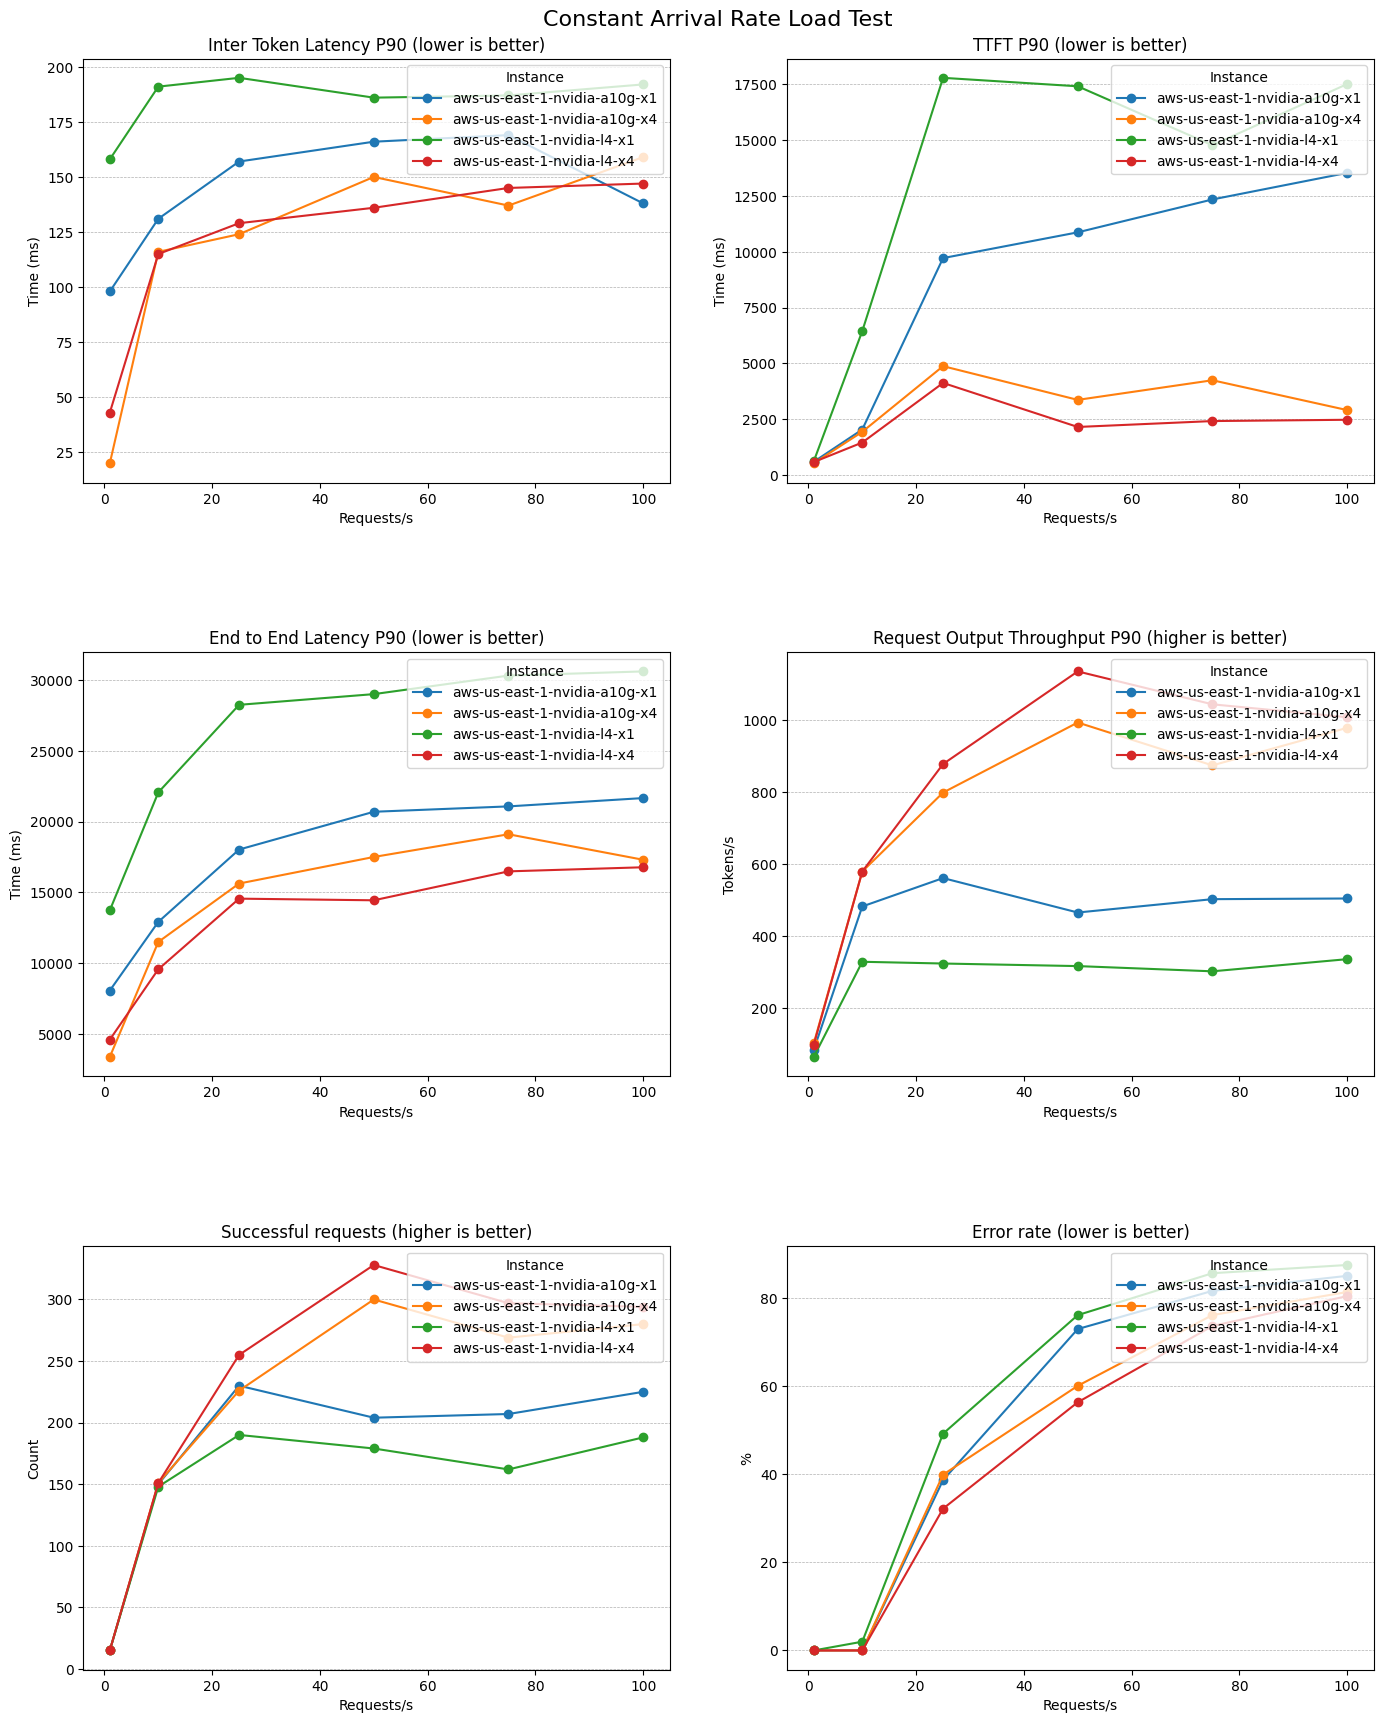

In [36]:
plot_metrics(
    df=results_df,
    file_name=os.path.join(DIR, "benchmark_report"),
)